In [34]:
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets

from IPython.display import display

In [35]:
NUM_STATES = 4
NUM_OBSERVATIONS = 2
NUM_BELIEFS = 2 # TARGET vs. NON TARGET
ANGLE_RANGE = 2*np.pi

STATE_STEP = ANGLE_RANGE/NUM_STATES
STATE_CENTERS = np.arange(0, ANGLE_RANGE, STATE_STEP) + STATE_STEP
ANGL_DIST_BETWEEN_STATES = (STATE_CENTERS[np.newaxis, :] - STATE_CENTERS[:, np.newaxis])

PRIOR_TARGET_PROB = np.array([1/NUM_BELIEFS, 1-(1/NUM_BELIEFS)])
PRIOR_STATE_PROB = np.full(NUM_STATES, 1/NUM_STATES)
LIKELIHOOD_OBS_FROM_NONTARGET = 1/NUM_OBSERVATIONS

In [36]:
STATE_STEP

1.5707963267948966

In [37]:
def get_state_transition_matrix(candidate_step):
    if candidate_step>0:
        mod_basis = 2*np.pi
    else:
        mod_basis = -2*np.pi

    angular_dist_between_states_in_extent = ANGL_DIST_BETWEEN_STATES % mod_basis
    angular_dist_after_action = (angular_dist_between_states_in_extent - candidate_step)
    angular_dist_after_action_in_extent = angular_dist_after_action % mod_basis
    
    sigma = STATE_STEP/10
    magnitude = 1 / np.sqrt((2*np.pi) * (sigma**2))
    state_transition = magnitude * np.exp(-0.5*((angular_dist_after_action_in_extent/sigma)**2))
    state_transition_normed = state_transition / state_transition.sum(axis=1)
    return state_transition_normed

In [38]:
candidate_step = -STATE_STEP
state_transition_matrix = get_state_transition_matrix(candidate_step)
state_transition_matrix.round(3)

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

In [39]:
candidate_step = 0
state_transition_matrix = get_state_transition_matrix(candidate_step)
state_transition_matrix.round(3)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [40]:
candidate_step = STATE_STEP
state_transition_matrix = get_state_transition_matrix(candidate_step)
state_transition_matrix.round(3)

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]])

In [41]:
obs1_bounds = np.array([60, 120])

In [42]:
def observe_angle_state_pair(initial_angle):
   plt.figure(figsize=(6, 6))
   radius = 1
   radius_until = 5
   pie = np.pi
   theta_obs1 = np.linspace(np.radians(obs1_bounds[0]), np.radians(obs1_bounds[1]), 30)
   x_inner = radius * np.cos(theta_obs1)
   y_inner =  radius * np.sin(theta_obs1)
   x_poly = np.concatenate([radius_until*x_inner, x_inner[::-1]])
   y_poly = np.concatenate([radius_until*y_inner, y_inner[::-1]])
   plt.fill(x_poly, y_poly, facecolor='blue', alpha=0.25, linewidth=0)
   plt.plot(x_inner, y_inner, color='blue', linewidth=1)

   theta_obs0 = np.linspace(np.radians(obs1_bounds[1]), np.radians(obs1_bounds[0])+2*pie, 30)
   x_inner = radius * np.cos(theta_obs0)
   y_inner =  radius * np.sin(theta_obs0)
   x_poly = np.concatenate([radius_until*x_inner, x_inner[::-1]])
   y_poly = np.concatenate([radius_until*y_inner, y_inner[::-1]])
   plt.fill(x_poly, y_poly, facecolor='orange', alpha=0.25, linewidth=0)
   plt.plot(x_inner, y_inner, color='orange', linewidth=1)

   for theta in STATE_CENTERS:
      r_outer = 4 * radius_until * radius
      plt.plot([radius*np.cos(theta), r_outer*np.cos(theta)], 
               [radius*np.sin(theta), r_outer*np.sin(theta)],
                  color='k', linewidth=1.5, solid_capstyle='round', zorder=1)
      plt.plot([radius*np.cos(theta + (STATE_STEP/2)), r_outer*np.cos(theta + (STATE_STEP/2))], 
               [radius*np.sin(theta + (STATE_STEP/2)), r_outer*np.sin(theta + (STATE_STEP/2))],
                  color='k', linewidth=1, linestyle='dashed', zorder=1)
      
   if initial_angle >= obs1_bounds[0] and initial_angle <= obs1_bounds[1]:
      code_received = 1
   else:
      code_received = 0
   initial_radians = np.radians((initial_angle % 360))
   initial_state = np.floor((initial_radians) / STATE_STEP)
   plt.scatter(radius_until*radius*np.cos(initial_radians), radius_until*radius*np.sin(initial_radians),
            s=200, marker='.', facecolor='r', edgecolor='k', zorder=4, label=f'State={initial_state}\nCode={code_received}')

   plt.gca().set_aspect('equal', adjustable='box')
   plt.xticks([])
   plt.yticks([])
   GRID_EXTENT = 7
   plt.xlim(-GRID_EXTENT, GRID_EXTENT)
   plt.ylim(-GRID_EXTENT, GRID_EXTENT)
   plt.legend()
   plt.show()


In [43]:
initial_angle_slider = widgets.IntSlider(
    value=0,  
    min=0,
    max=360,
    description="Initial Angle",
    style={'description_width': 'initial'},
    continuous_update=True,
    layout=widgets.Layout(width="600px"),
)

interactive_plot = widgets.interactive(
    observe_angle_state_pair, initial_angle=initial_angle_slider)
display(interactive_plot)

interactive(children=(IntSlider(value=0, description='Initial Angle', layout=Layout(width='600px'), max=360, s…

In [44]:
code0_extent_in_states = np.zeros(NUM_STATES) + STATE_STEP
code0_extent_in_states[1] = 0
code1_extent_in_states = np.zeros(NUM_STATES)
code1_extent_in_states[1] = STATE_STEP

prob_code0_in_states = code0_extent_in_states / STATE_STEP
prob_code1_in_states = code1_extent_in_states / STATE_STEP

EMISSION_MATRIX_B = np.vstack([prob_code0_in_states, prob_code1_in_states])
EMISSION_MATRIX_B

array([[1., 0., 1., 1.],
       [0., 1., 0., 0.]])

In [45]:
trial_num = 0
num_trials = 10
max_iter = 50
posterior_across_trials = np.zeros((num_trials, max_iter+1, NUM_BELIEFS))

In [46]:
joint_prob_obs_state_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[0], EMISSION_MATRIX_B.shape[1]))
joint_prob_received_obs_state_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[1]))
joint_prob_obs_state_forecast_t = np.zeros((max_iter, EMISSION_MATRIX_B.shape[0], EMISSION_MATRIX_B.shape[1]))
likelihood_received_obs_from_target_t = np.zeros(max_iter)
angles_visited = np.zeros(max_iter)
posterior_t = np.zeros((max_iter, NUM_BELIEFS))
current_entropyS_t = np.zeros(max_iter)
candidate_steps = np.array([-STATE_STEP, STATE_STEP])
expected_forecast_t_S_per_step = np.zeros((max_iter, candidate_steps.shape[0]))
deltaS_t = np.zeros((max_iter, candidate_steps.shape[0]))
code_received_t = np.zeros(max_iter)

time_ind = 0
initial_angle = 0

while time_ind<max_iter:
    if time_ind<1:
        angles_visited[time_ind] = initial_angle
    else:
        angles_visited[time_ind] = angles_visited[time_ind-1] + np.rad2deg(step_to_take)

    if (angles_visited[time_ind]%360) >= obs1_bounds[0] and (angles_visited[time_ind]%360) <= obs1_bounds[1]:
        code_received_t[time_ind] = 1
    else:
        code_received_t[time_ind] = 0
    print(f'Current angle: {angles_visited[time_ind]}, Code received: {code_received_t[time_ind]}')
    # observe_angle_state_pair((angles_visited[time_ind]%360))

    joint_prob_obs_state_t[time_ind] = PRIOR_STATE_PROB * EMISSION_MATRIX_B

    joint_prob_received_obs_state_t[time_ind] = joint_prob_obs_state_t[time_ind][int(code_received_t[time_ind])]
    likelihood_received_obs_from_target_t[time_ind] = joint_prob_received_obs_state_t[time_ind].sum()

    if time_ind<1:
        likelihood_received_obs = np.array([likelihood_received_obs_from_target_t[time_ind], LIKELIHOOD_OBS_FROM_NONTARGET])
        posterior_t[time_ind] = (PRIOR_TARGET_PROB*likelihood_received_obs) / (PRIOR_TARGET_PROB*likelihood_received_obs).sum()
    else:
        likelihood_received_obs = np.array([likelihood_received_obs_from_target_t[time_ind], LIKELIHOOD_OBS_FROM_NONTARGET])
        posterior_t[time_ind] = (posterior_t[time_ind-1]*likelihood_received_obs) / (posterior_t[time_ind-1]*likelihood_received_obs).sum()

    if 1 in posterior_t[time_ind]:
        current_entropyS_t[time_ind] = 0
    else:
        current_entropyS_t[time_ind] = (-posterior_t[time_ind]*np.log2(posterior_t[time_ind])).sum()

    print(f"P(O1:{int(time_ind+1)},S{int(time_ind+1)}|T)={joint_prob_received_obs_state_t[time_ind].round(2)}, P(O1:{int(time_ind+1)}|actions,T)={likelihood_received_obs_from_target_t[time_ind]}, P(T|O1:{int(time_ind+1)})={posterior_t[time_ind]}, H{int(time_ind+1)}={current_entropyS_t[time_ind]:.2f}")

    for i, forecast_t_candidate_step in enumerate(candidate_steps):
        state_transition_matrix = np.round(get_state_transition_matrix(forecast_t_candidate_step))

        joint_prob_obs_state_forecast_t[time_ind] = PRIOR_STATE_PROB * EMISSION_MATRIX_B
        likelihood_obs_from_target_forecast_t = joint_prob_obs_state_forecast_t[time_ind].sum(axis=1)

        likelihood_obs0_forecast_t_given_received_obs = np.array([likelihood_obs_from_target_forecast_t[0], LIKELIHOOD_OBS_FROM_NONTARGET])
        posterior_forecast_given_received_obs0 = (posterior_t[time_ind] * likelihood_obs0_forecast_t_given_received_obs) / (posterior_t[time_ind] * likelihood_obs0_forecast_t_given_received_obs).sum()

        likelihood_obs1_forecast_t_given_received_obs = np.array([likelihood_obs_from_target_forecast_t[1], LIKELIHOOD_OBS_FROM_NONTARGET])
        posterior_forecast_given_received_obs1 = (posterior_t[time_ind] * likelihood_obs1_forecast_t_given_received_obs) / (posterior_t[time_ind] * likelihood_obs1_forecast_t_given_received_obs).sum()

        if 1 in posterior_forecast_given_received_obs0:
            forecasted_S0 = 0
        else:
            forecasted_S0 = (-posterior_forecast_given_received_obs0 * np.log2(posterior_forecast_given_received_obs0)).sum()

        if 1 in posterior_forecast_given_received_obs1:
            forecasted_S1 = 0
        else:
            forecasted_S1 = (-posterior_forecast_given_received_obs1 * np.log2(posterior_forecast_given_received_obs1)).sum()

        prob_obs0_at_forecast_t2_given_obs0_at_t1 = (posterior_t[time_ind] * np.array([likelihood_obs_from_target_forecast_t[0], LIKELIHOOD_OBS_FROM_NONTARGET])).sum()
        prob_obs1_at_forecast_t2_given_obs0_at_t1 = (posterior_t[time_ind] * np.array([likelihood_obs_from_target_forecast_t[1], LIKELIHOOD_OBS_FROM_NONTARGET])).sum()

        expected_forecast_t_S = (forecasted_S0 * prob_obs0_at_forecast_t2_given_obs0_at_t1) + (forecasted_S1 * prob_obs1_at_forecast_t2_given_obs0_at_t1)
        expected_forecast_t_S_per_step[time_ind, i] = expected_forecast_t_S

    deltaS_t[time_ind] = current_entropyS_t[time_ind] - expected_forecast_t_S_per_step[time_ind]
    print(f'PRINT 1: {current_entropyS_t[time_ind]}, {joint_prob_received_obs_state_t[time_ind]}')
    print(f'PRINT 2: {deltaS_t[time_ind]}, {posterior_t[time_ind]}')

    if (deltaS_t[time_ind]==deltaS_t[time_ind][0]).all():
        print('Choosing randomly')
        step_to_take = candidate_steps[np.random.choice(np.arange(0, len(deltaS_t[time_ind])))]
    else:
        print('Choosing according to max ΔS')
        step_to_take = candidate_steps[deltaS_t[time_ind].argmax()]

    time_ind+=1

posterior_across_trials[trial_num,:,:] = np.vstack([PRIOR_TARGET_PROB, posterior_t[:time_ind]])

Current angle: 0.0, Code received: 0.0
P(O1:1,S1|T)=[0.25 0.   0.25 0.25], P(O1:1|actions,T)=0.75, P(T|O1:1)=[0.6 0.4], H1=0.97
PRINT 1: 0.9709505944546686, [0.25 0.   0.25 0.25]
PRINT 2: [0.04730118 0.04730118], [0.6 0.4]
Choosing randomly
Current angle: 90.0, Code received: 1.0
P(O1:2,S2|T)=[0.   0.25 0.   0.  ], P(O1:2|actions,T)=0.25, P(T|O1:2)=[0.42857143 0.57142857], H2=0.99
PRINT 1: 0.9852281360342514, [0.   0.25 0.   0.  ]
PRINT 2: [0.04749944 0.04749944], [0.42857143 0.57142857]
Choosing randomly
Current angle: 180.0, Code received: 0.0
P(O1:3,S3|T)=[0.25 0.   0.25 0.25], P(O1:3|actions,T)=0.75, P(T|O1:3)=[0.52941176 0.47058824], H3=1.00
PRINT 1: 0.9975025463691152, [0.25 0.   0.25 0.25]
PRINT 2: [0.04875988 0.04875988], [0.52941176 0.47058824]
Choosing randomly
Current angle: 90.0, Code received: 1.0
P(O1:4,S4|T)=[0.   0.25 0.   0.  ], P(O1:4|actions,T)=0.25, P(T|O1:4)=[0.36 0.64], H4=0.94
PRINT 1: 0.9426831892554923, [0.   0.25 0.   0.  ]
PRINT 2: [0.04444034 0.04444034], [0

In [47]:
import matplotlib.animation as animation

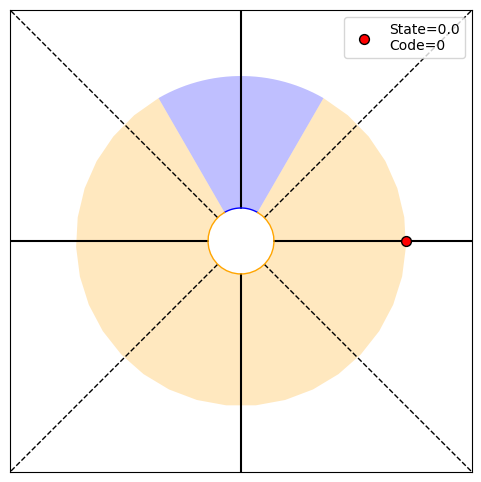

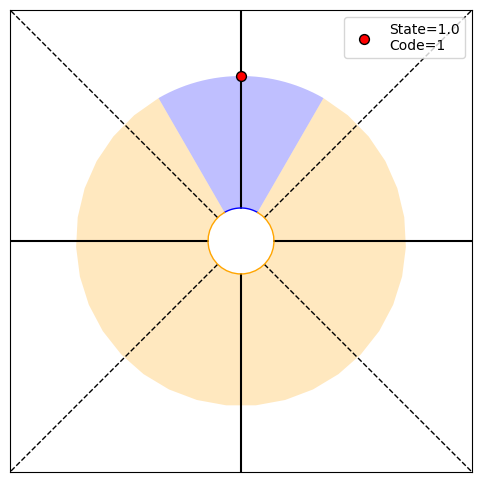

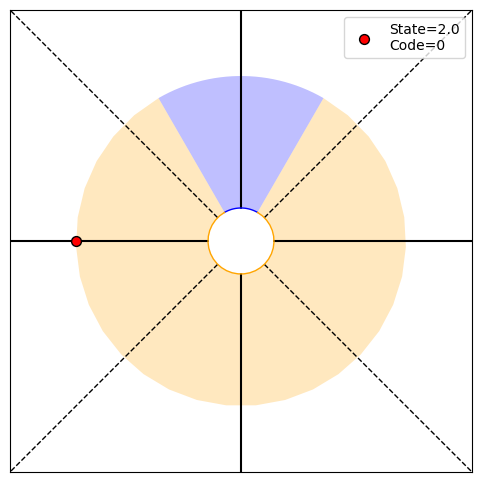

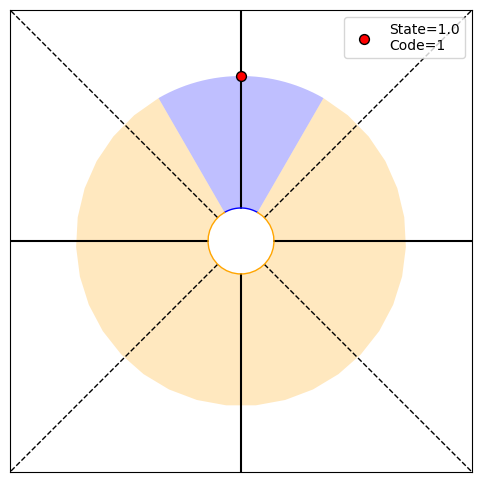

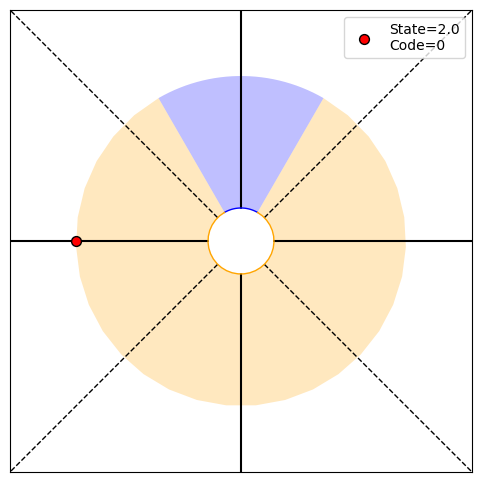

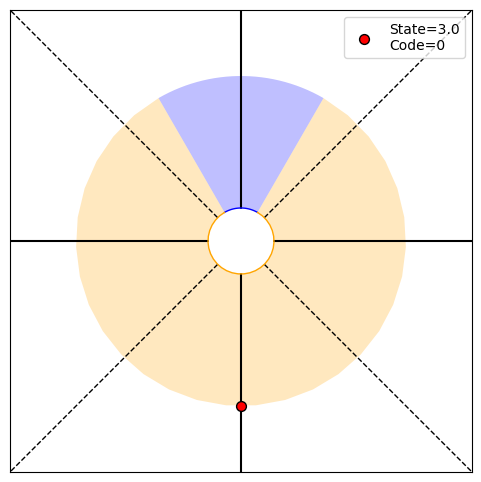

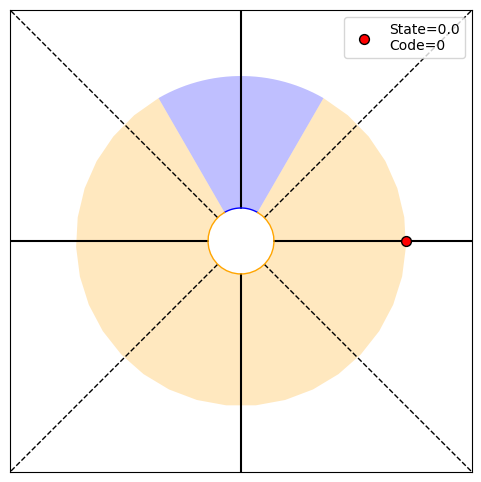

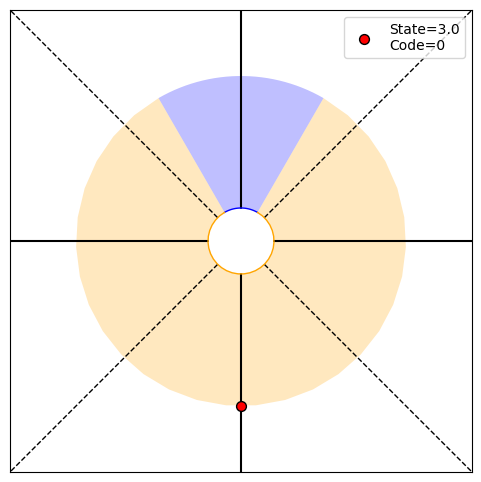

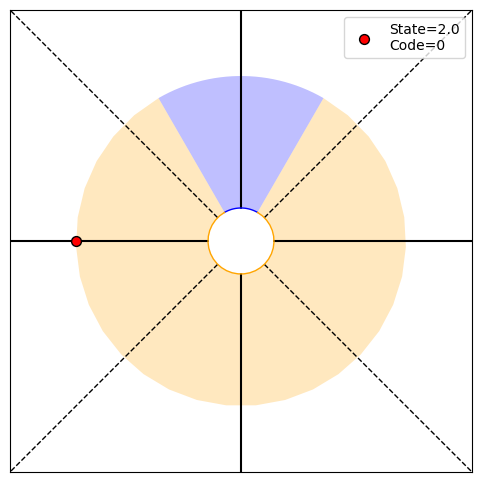

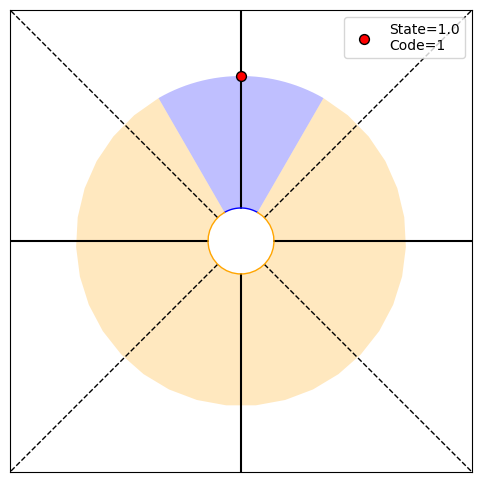

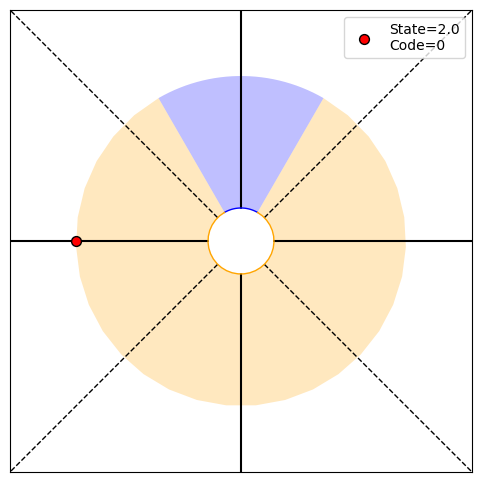

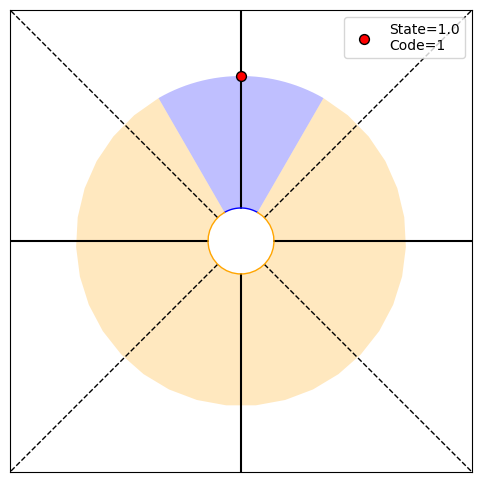

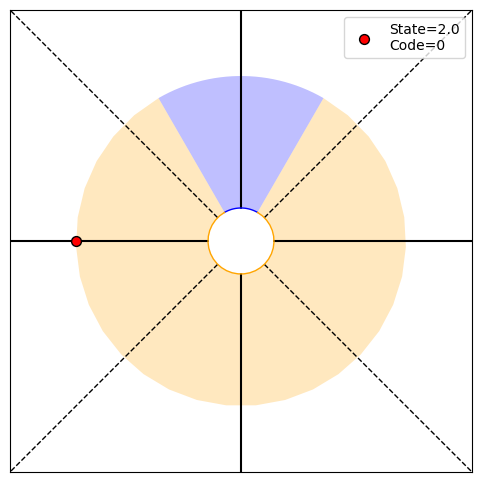

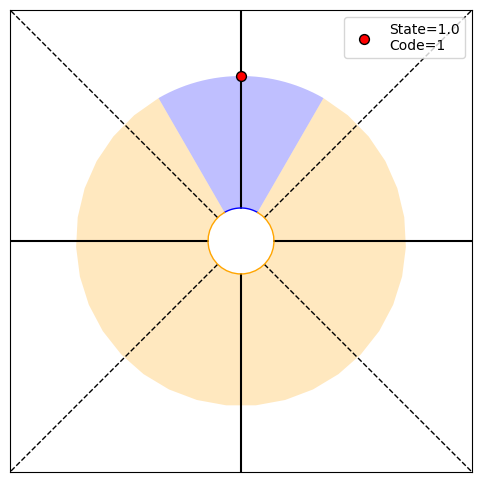

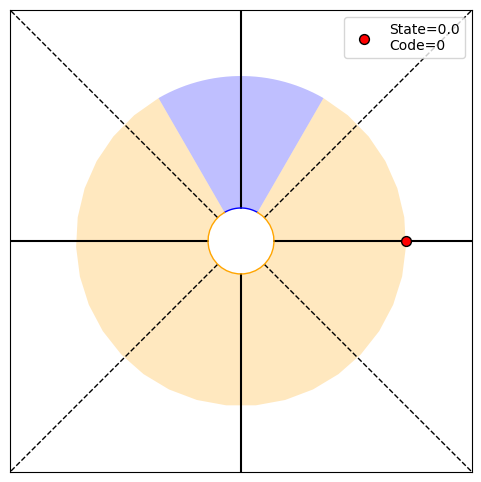

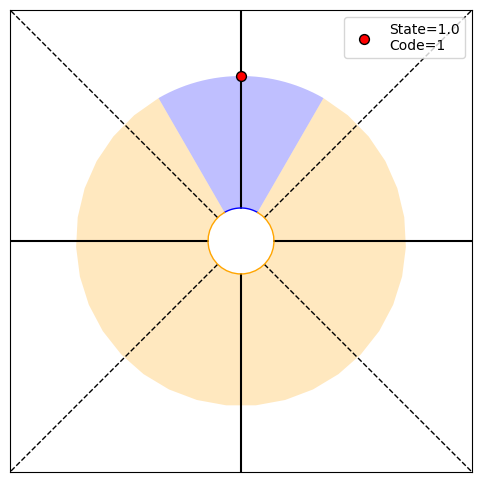

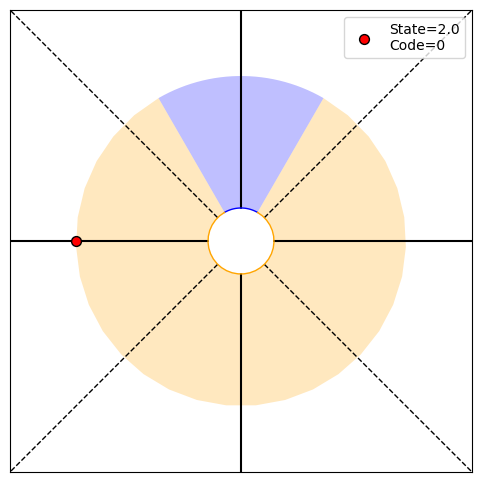

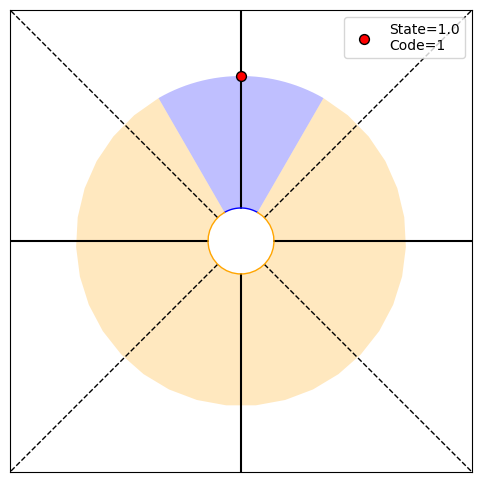

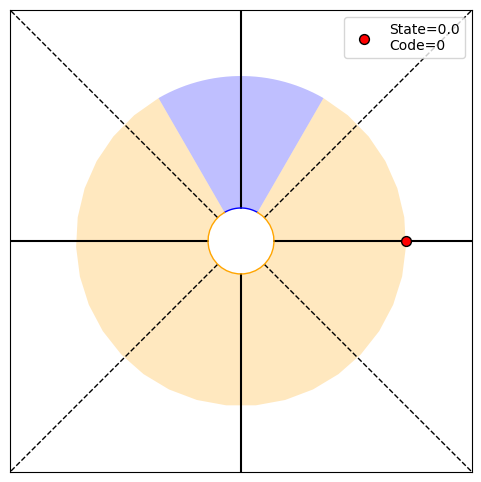

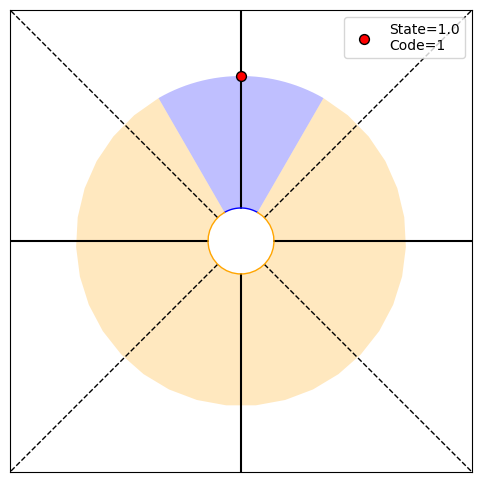

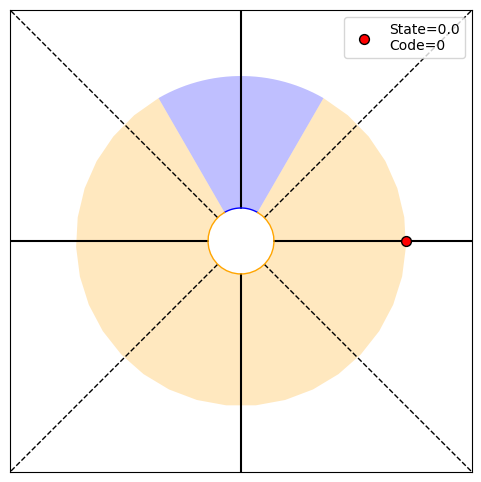

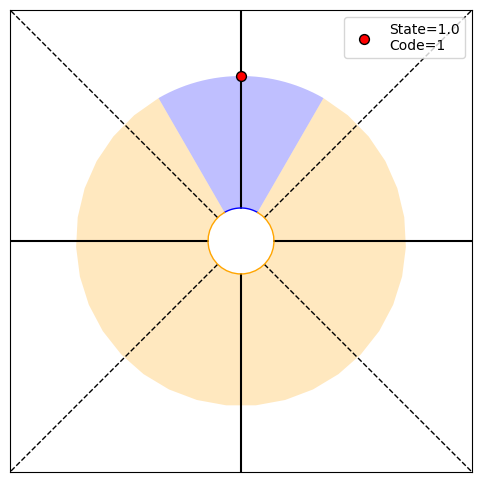

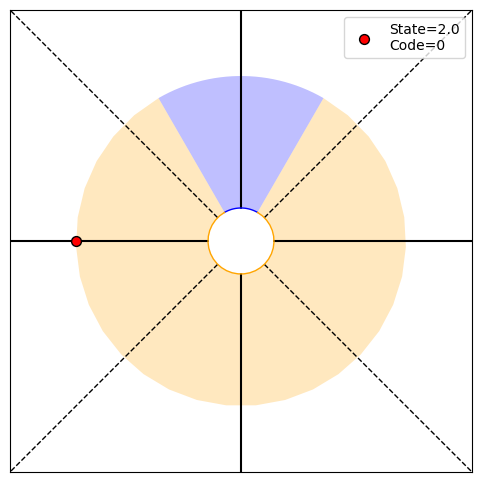

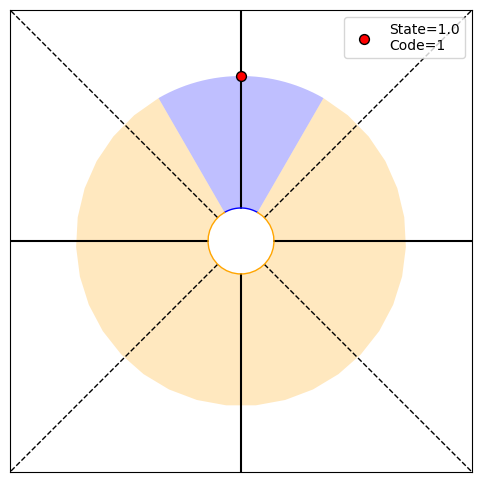

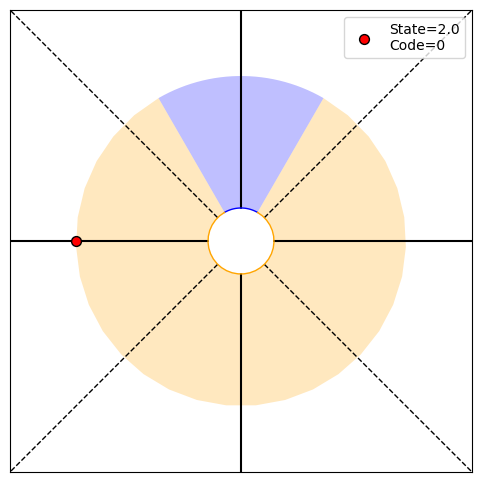

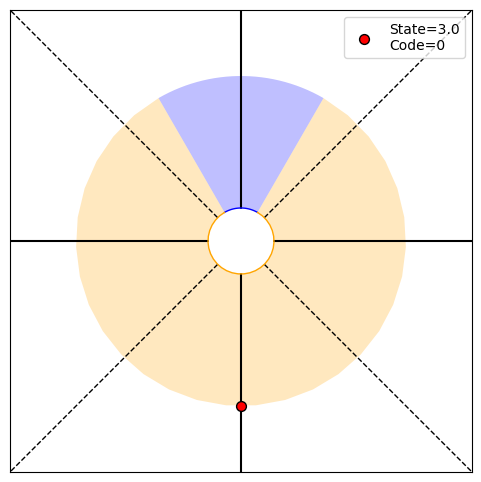

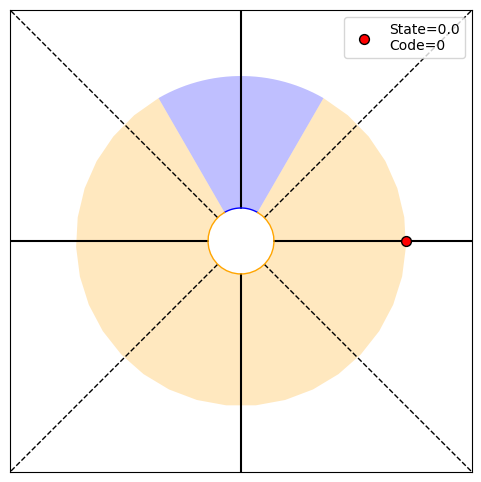

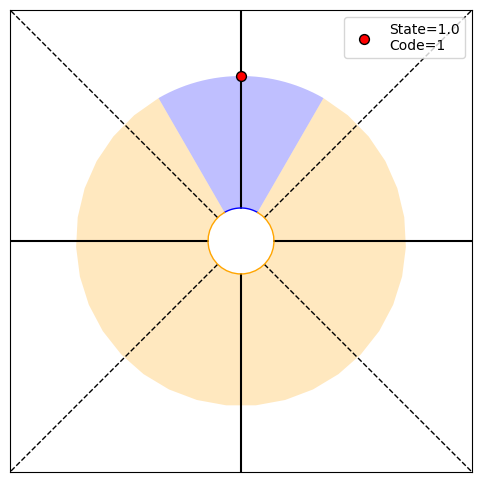

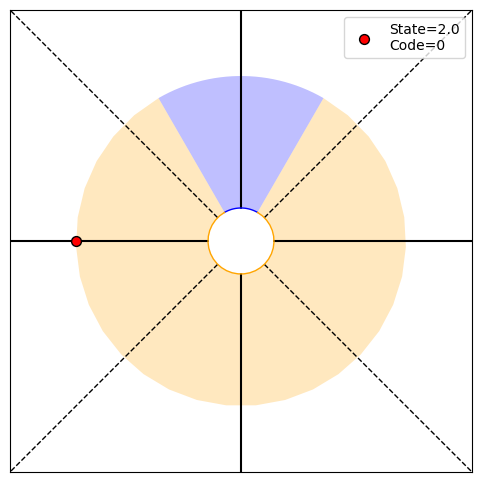

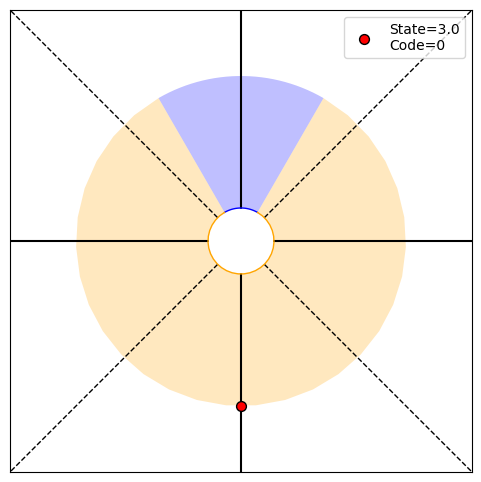

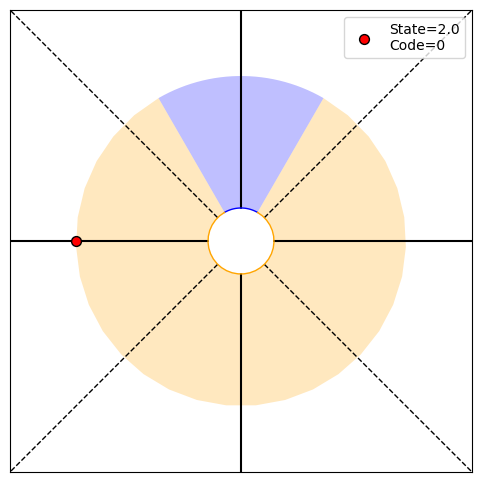

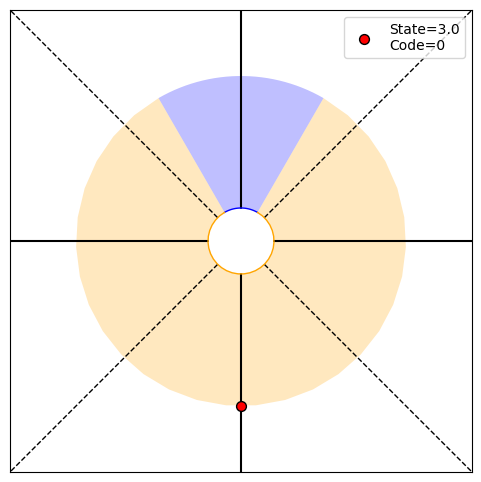

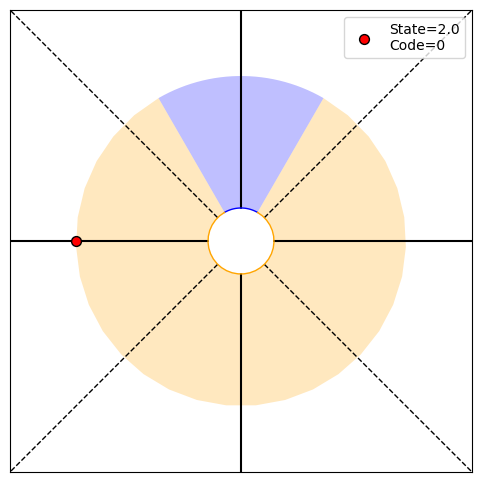

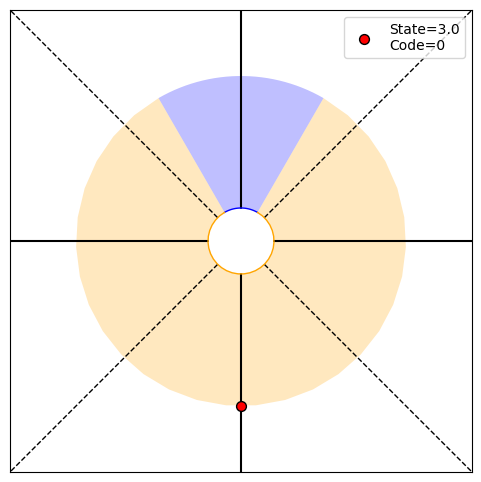

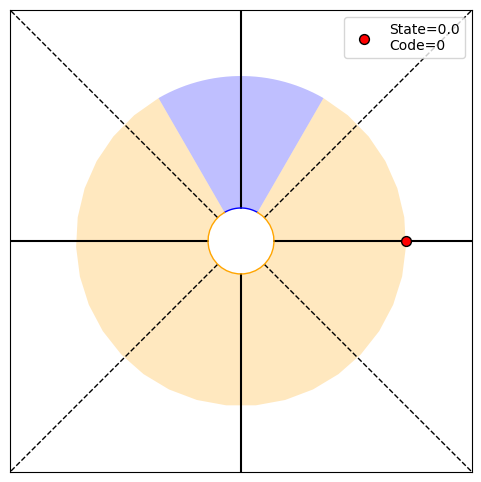

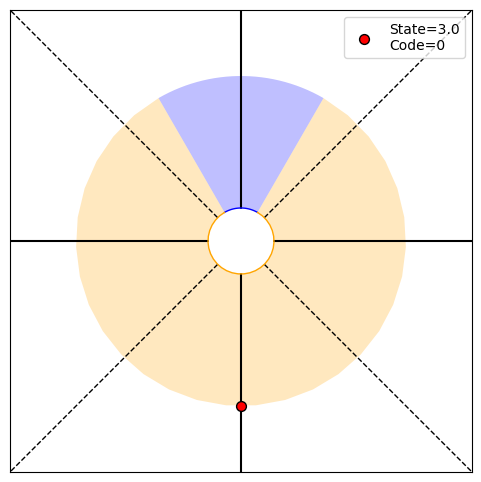

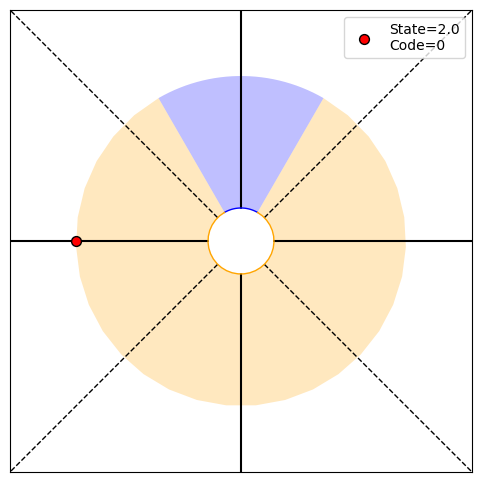

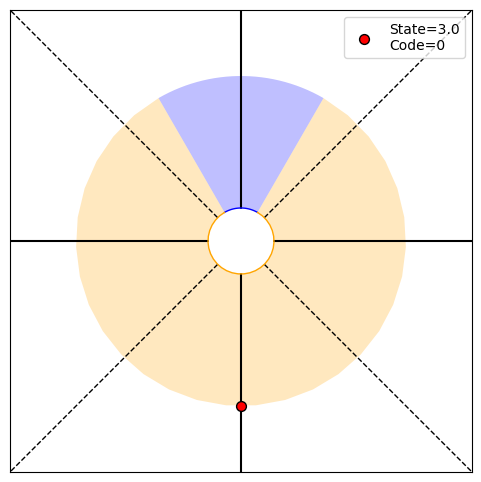

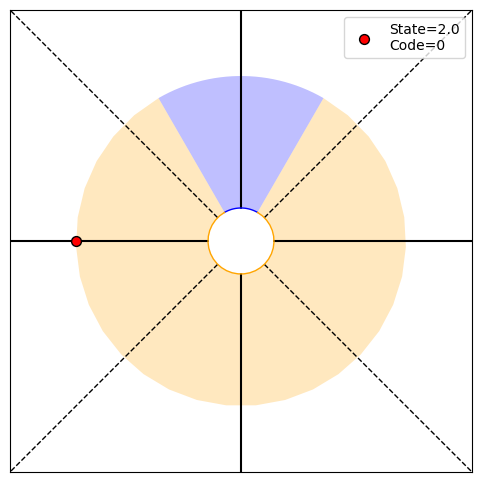

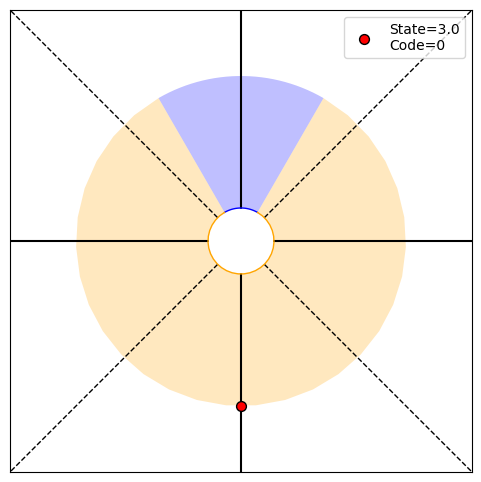

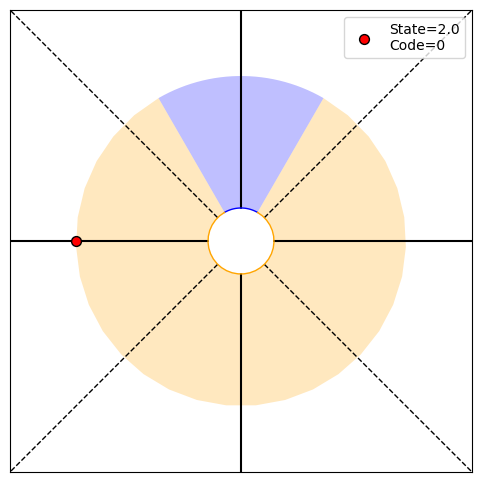

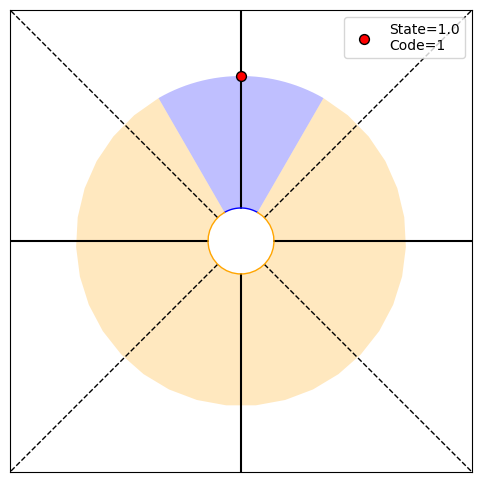

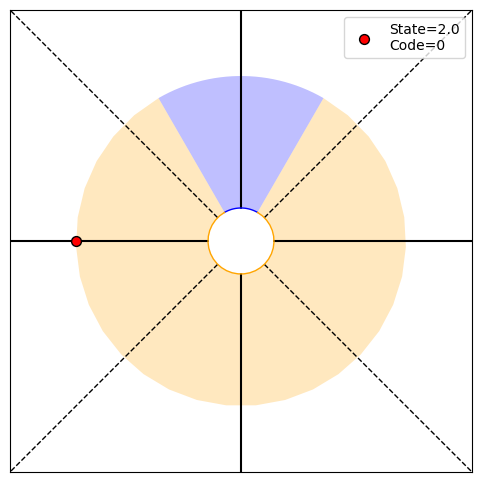

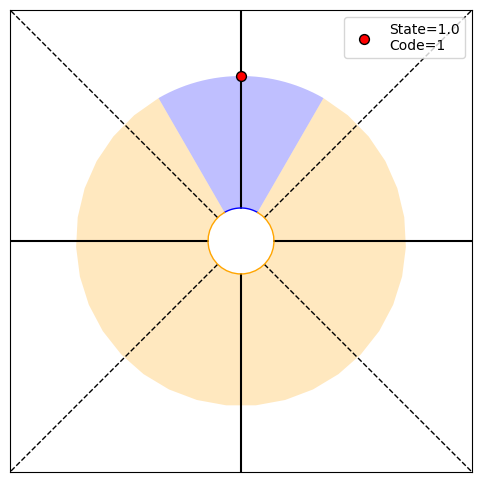

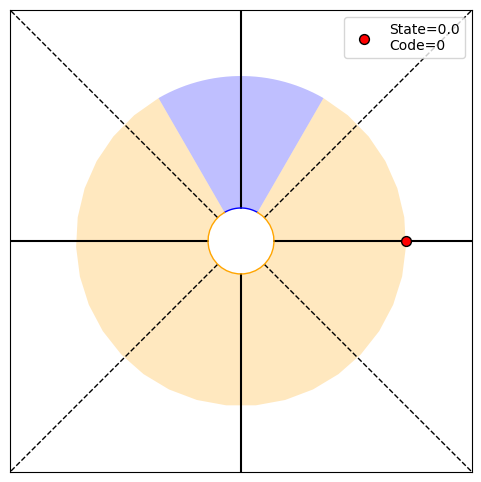

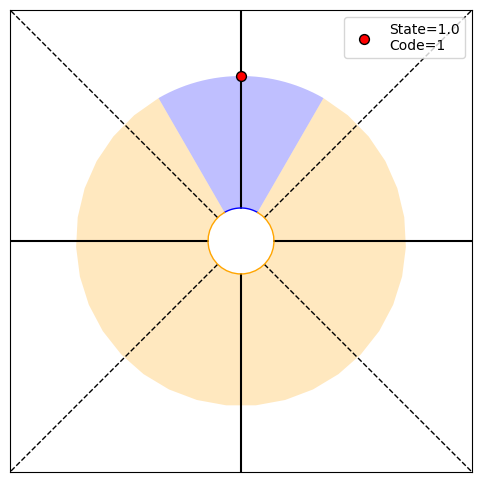

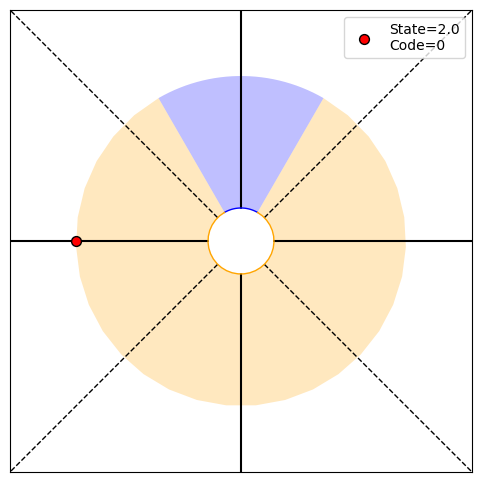

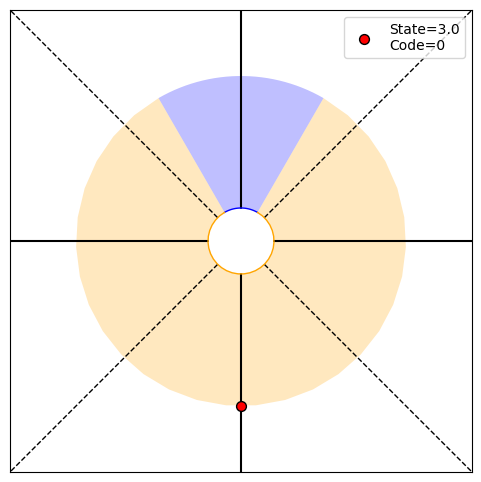

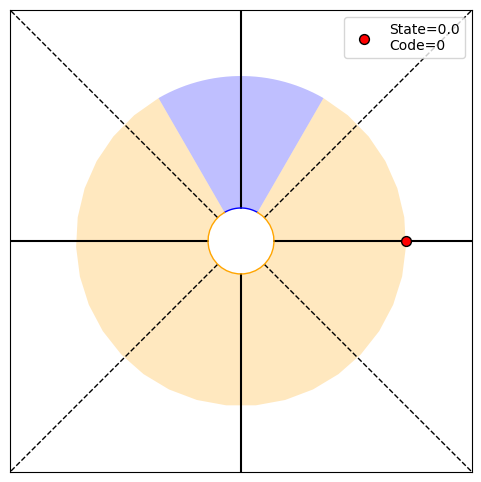

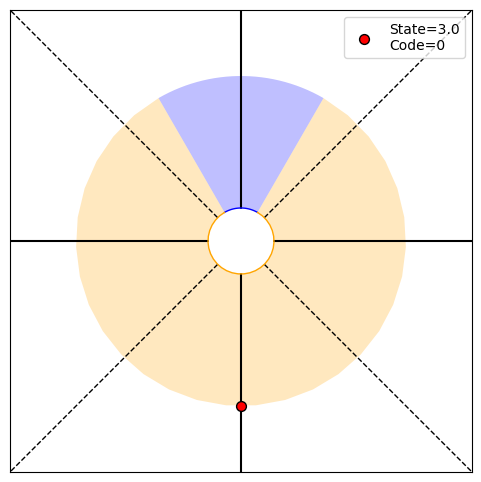

In [48]:
time_ind = 0
trial_stop_time_ind = 0
while time_ind<max_iter:
    if np.isclose(posterior_t[time_ind], 1).any():
        trial_stop_time_ind = time_ind
        break
    else:
        observe_angle_state_pair((angles_visited[time_ind]%360))
    time_ind+=1
    trial_stop_time_ind = time_ind

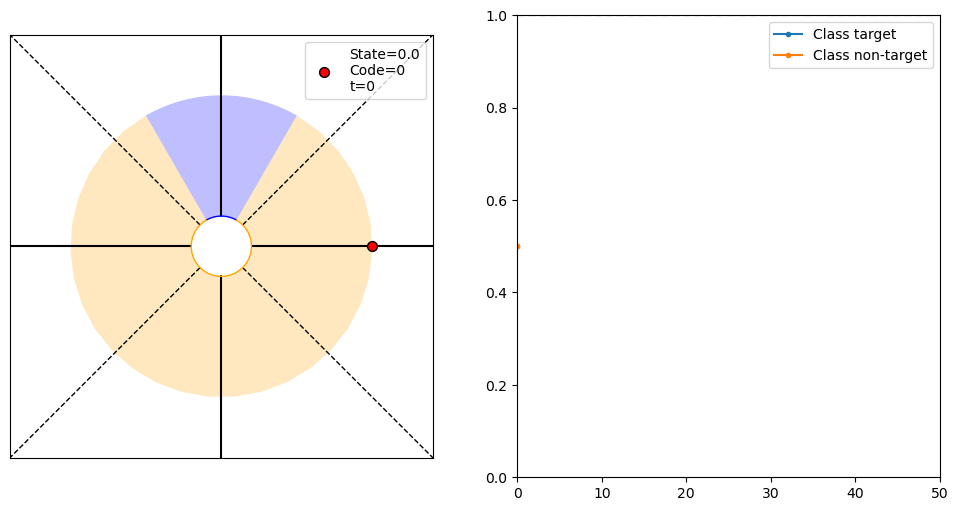

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

def update(time_ind):
    ax_grid = ax[0]
    ax_diffusion = ax[1]
    ax_grid.cla()
    ax_diffusion.cla()

    radius = 1
    radius_until = 5
    pie = np.pi
    theta_obs1 = np.linspace(np.radians(obs1_bounds[0]), np.radians(obs1_bounds[1]), 30)
    x_inner = radius * np.cos(theta_obs1)
    y_inner =  radius * np.sin(theta_obs1)
    x_poly = np.concatenate([radius_until*x_inner, x_inner[::-1]])
    y_poly = np.concatenate([radius_until*y_inner, y_inner[::-1]])
    ax_grid.fill(x_poly, y_poly, facecolor='blue', alpha=0.25, linewidth=0)
    ax_grid.plot(x_inner, y_inner, color='blue', linewidth=1)

    theta_obs0 = np.linspace(np.radians(obs1_bounds[1]), np.radians(obs1_bounds[0])+2*pie, 30)
    x_inner = radius * np.cos(theta_obs0)
    y_inner =  radius * np.sin(theta_obs0)
    x_poly = np.concatenate([radius_until*x_inner, x_inner[::-1]])
    y_poly = np.concatenate([radius_until*y_inner, y_inner[::-1]])
    ax_grid.fill(x_poly, y_poly, facecolor='orange', alpha=0.25, linewidth=0)
    ax_grid.plot(x_inner, y_inner, color='orange', linewidth=1)

    for theta in STATE_CENTERS:
        r_outer = 4 * radius_until * radius
        ax_grid.plot([radius*np.cos(theta), r_outer*np.cos(theta)], 
                [radius*np.sin(theta), r_outer*np.sin(theta)],
                    color='k', linewidth=1.5, solid_capstyle='round', zorder=1)
        ax_grid.plot([radius*np.cos(theta + (STATE_STEP/2)), r_outer*np.cos(theta + (STATE_STEP/2))], 
                [radius*np.sin(theta + (STATE_STEP/2)), r_outer*np.sin(theta + (STATE_STEP/2))],
                    color='k', linewidth=1, linestyle='dashed', zorder=1)
        
    if (angles_visited[time_ind]%360) >= obs1_bounds[0] and (angles_visited[time_ind]%360) <= obs1_bounds[1]:
        code_received = 1
    else:
        code_received = 0
    initial_radians = np.radians(((angles_visited[time_ind]%360) % 360))
    initial_state = np.floor((initial_radians) / STATE_STEP)
    ax_grid.scatter(radius_until*radius*np.cos(initial_radians), radius_until*radius*np.sin(initial_radians),
            s=200, marker='.', facecolor='r', edgecolor='k', zorder=4, label=f'State={initial_state}\nCode={code_received}\nt={time_ind}')
    
    ax_grid.set_aspect('equal', adjustable='box')
    ax_grid.set_xticks([])
    ax_grid.set_yticks([])
    GRID_EXTENT = 7
    ax_grid.set_xlim(-GRID_EXTENT, GRID_EXTENT)
    ax_grid.set_ylim(-GRID_EXTENT, GRID_EXTENT)
    ax_grid.legend()

    for i in range(NUM_BELIEFS):
        if i == 0:
            class_name = 'target'
        else:
            class_name = 'non-target'
        ax_diffusion.plot(np.vstack([PRIOR_TARGET_PROB, posterior_t[:max(0,time_ind)]])[:,i], marker='.', label=f'Class {class_name}')
    ax_diffusion.axhline(y=1.0, linestyle='dashed', color='k')
    ax_diffusion.set_xlim(0, trial_stop_time_ind)
    ax_diffusion.set_ylim(0, 1.0)
    ax_diffusion.legend()

ani = animation.FuncAnimation(fig=fig, func=update, frames=trial_stop_time_ind, interval=600)
ani.save('memoryless_test.mp4')